# Loan Approval Prediction
Edmund Walsh - May 10th, 2020

## Introduction
The project examines the data provided by the Home Mortgage Disclosure Act (HMDA) which requires mortgage lenders in the United States to disclose information about the mortgage lending decisions they have made. Specifically, we will be examining prediction of whether or not an application will be accepted or denied.

This notebook is part of a short 5-day project whose purpose is more about process than prediction of mortgages. The focus of this project will be setting up end-to-end engineering from raw data to results and presentation that will help us scale in the future. This notebook will focus on the data science approach and process and highlight a roadmap best illustrated in the image below:

<img src='https://miro.medium.com/max/1400/1*LoBdYL_YyIcYJ842peLDpQ.jpeg'
     alt='Data Science & Data Engineering'
     style='height: 350px; width: 750px;' />

## A Ground Up Approach
The pyramid above is such a good illustration because the process truly is building in a step-by-step fashion 
towards the ultimate goal of finding useful results that are actionable and impactful in the real world. 
The end results get all of the attention, but a project is unlikely to be successful without these strong foundations.

## Context 
While this project request didn't specifically state 'why' we are looking into this data, I will work within the context of three important rationales.
1. Mortgage due diligence is expensive and time intensive. A process that can more reliably expidite the process will save lenders significant time and resources.
2. From a regulatory perspective and also importantly as Machine Intelligence becomse a larger and more common part of this process it is important for us to be aware of and highlight any bias.
3. Some financial instituions may be more or less likely to issue mortgages and this may reflect either an over or under utilization of the balance sheet or their risk appetite.

### Preparation
Before digging in, let's install our python requirements and follow the instructions for setting up our docker environment and tools in the [README.md](https://github.com/ewalsh/hmda/blob/master/README.md)

In [1]:
pip install --user -r ./misc/requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Package Import
Now we can begin importing the required packages. Many of these are common python packages, the exception is seed which is a set of functions we will use to import our initial data and begin our collect step on our roadmap.

In [2]:
import seed
import pandas as pd
import numpy as np
import os
import config
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

### A Discussion of the data
Our data sources will come from three major sources and we will use their APIs to download the data.
<br />
1. Our main dataset comes from the HMDA database and includes not only a large set of information about the individual loan approval decision but also information about the originating institutions.
<br /> <br />
    a. A full list of available data on the mortgage approvals can be found [here](http://cfpb.github.io/api/hmda/fields.html)
    <br />
    b. We also will look at the originating instituions and information about that dataset can 
    be found [here](https://api.consumerfinance.gov/data/hmda/slice/institutions/metadata)
    <br /> <br />
2. Our next and complementary set of information comes from the census bureau. We will use their county business patterns series which aggregate economic information at a county level. I hope that this information will provide some valueable economic insight into regional economics that may affect an mortgage approval decision. <br /> <br />
    a. Details about this dataset can be found [here](https://www.census.gov/programs-surveys/cbp.html) <br />
    b. This API requires a key which you can sign up for [here](https://api.census.gov/data/key_signup.html) <br />
    c. After you have signed up, please include this key in the [config.py](https://github.com/ewalsh/hmda/blob/master/py_code/config.py) file. <br /> <br />
3. Finally, we will also fill in some data from Federal Reserve Bank of St. Louis. This data will come into use towards the end of the project as we begin to look across time periods as it should give us an indication of both the financial conditions and sentiment of the originating institutions. <br /> <br />
    a. Details about this API can be found [here](https://fred.stlouisfed.org/docs/api/fred/)

In [3]:
# after configuring the census API re-import config and check api key
import config
print(config.api_key)

8dadaedad2b940dd8ffff397507286b479540d00


### Data Collection
Luckily for us, the designers of the APIs have made this pretty easy. A big thank you to them!

I have selected a single year and a single state. Feel free to change to your preferences, data is available from 2007 - 2017. Some important caveats. As this is an illustrative project only, there are some important details about availability of data (i.e. when it was published) and data type issues that would require more attention in a production environment.

In [4]:
# choose a first state by two letter code and year
init_state = "OH"
init_yr = 2016

In [5]:
# pull data from the HMDA database on mortgage approvals -- this may take awhile
data_lar = seed.lar_pull(init_state, init_yr)

In [6]:
# a quick data snapshot
data_lar.head() 

,action_taken,action_taken_name,agency_code,agency_abbr,agency_name,applicant_ethnicity,applicant_ethnicity_name,applicant_income_000s,applicant_race_1,applicant_race_2,...,state_name,hud_median_family_income,loan_amount_000s,number_of_1_to_4_family_units,number_of_owner_occupied_units,minority_population,population,rate_spread,tract_to_msamd_income,uuid
0,6,Loan purchased by the institution,7,HUD,Department of Housing and Urban Development,2,Not Hispanic or Latino,NaN,5,NaN,...,Ohio,66600,160,2423,1893,3.9200000762939453,6806,NaN,98.4000015258789,bdc885a5-14c1-4e4c-96c8-ebc1339dd96b
1,3,Application denied by financial institution,7,HUD,Department of Housing and Urban Development,2,Not Hispanic or Latino,60,5,NaN,...,Ohio,69100,293,3131,2921,16.459999084472656,8742,NaN,172.69000244140625,105633a6-bce9-46fb-82ac-3089aa5be460
2,1,Loan originated,7,HUD,Department of Housing and Urban Development,2,Not Hispanic or Latino,87,5,NaN,...,Ohio,66600,104,2320,1485,4.429999828338623,5508,NaN,89.05000305175781,c5c57129-adb9-4a47-bee4-e117482fd8c9
3,1,Loan originated,7,HUD,Department of Housing and Urban Development,2,Not Hispanic or Latino,86,5,NaN,...,Ohio,55400,153,948,809,2.490000009536743,2973,NaN,133.8300018310547,f61a9234-e2d0-473c-b4f2-35a11be83115
4,6,Loan purchased by the institution,9,CFPB,Consumer Financial Protection Bureau,2,Not Hispanic or Latino,124,5,NaN,...,Ohio,66600,122,2441,2002,2.9600000381469727,6307,NaN,129.35000610351562,84a38310-f0ce-4d6b-ae37-c6b1b024ff7b


In [7]:
'{:,.0f}'.format(data_lar.shape[0]) + ' total rows for a total of ' + \
'{:,.0f}'.format(data_lar.shape[0]*data_lar.shape[1]) + ' data points'

'493,271 total rows for a total of 38,968,409 data points'

In [8]:
# Now pull county business patters data from the census bureau
census_df = seed.census_pull(init_state, init_yr, data_lar, config.api_key)

In [9]:
# A quick snapshot
census_df.head()

,EMP,ESTAB,PAYANN,POP,county_code,county_name,state_abbr,state_code,year
0,293924,23317,11790930,171134,103,"Medina County, Ohio",OH,39,2016
1,3775265,169990,190400631,1138190,49,"Franklin County, Ohio",OH,39,2016
2,466581,35316,20664563,227255,85,"Lake County, Ohio",OH,39,2016
3,201710,14425,7926456,111289,169,"Wayne County, Ohio",OH,39,2016
4,2809075,125607,159909829,782863,61,"Hamilton County, Ohio",OH,39,2016


In [10]:
'{:,.0f}'.format(census_df.shape[0]) + ' total rows  for a total of ' + \
'{:,.0f}'.format(census_df.shape[0]*census_df.shape[1]) + ' data points'

'88 total rows  for a total of 792 data points'

In [11]:
# Finally, let's pull data about the originating institutions
data_inst = seed.inst_pull(init_state, init_yr)

In [12]:
# A quick snapshot
data_inst.head()

,activity_year,respondent_id,agency_code,agency_abbr,agency_name,federal_tax_id,respondent_name,respondent_address,respondent_city,respondent_state,...,parent_state,parent_zip_code,respondent_name_panel,respondent_city_panel,respondent_state_panel,other_lender_code,region_code,validity_error,assets,lar_count
0,2016,0000000046,1,OCC,Office of the Comptroller of the Currency,31-4247738,FIRST NATIONAL BANK OF MCCONNE,"86 N. KENNEBEC AVENUE, PO BOX 208",MCCONNELSVILLE,OH,...,OH,43756,FIRST NB,MCCONNELSVILLE,OH,0,3,N,138285,129
1,2016,0000000047,1,OCC,Office of the Comptroller of the Currency,35-0704860,FIRST FINANCIAL BANK NA,1401 S 3RD ST,TERRE HAUTE,IN,...,IN,47807,FIRST FNCL BK NA,TERRE HAUTE,IN,0,3,N,2882577,2695
2,2016,0000000086,1,OCC,Office of the Comptroller of the Currency,31-0294798,FIRST NATIONAL BANK OF GERMANT,17 NORTH MAIN STREET,GERMANTOWN,OH,...,NaN,NaN,FIRST NB,GERMANTOWN,OH,0,3,N,52364,38
3,2016,0000000324,1,OCC,Office of the Comptroller of the Currency,23-0916895,FIRST NATIONAL BANK AND TRUST,40 SOUTH STATE ST,NEWTOWN,PA,...,NaN,NaN,FIRST NB&TC NEWTOWN,NEWTOWN,PA,0,1,N,860869,184
4,2016,0000000325,1,OCC,Office of the Comptroller of the Currency,24-0558097,"FNB BANK, NA",354 MILL STREET,DANVILLE,PA,...,PA,17604,FNB BK NA,DANVILLE,PA,0,1,N,363285,270


In [13]:
'{:,.0f}'.format(data_inst.shape[0]) + ' total rows  for a total of ' + \
'{:,.0f}'.format(data_inst.shape[0]*data_inst.shape[1]) + ' data points'

'100 total rows  for a total of 2,400 data points'

### Data Storage
We are very early on, but we have already pulled together a rather large dataset. So, after building on our foundation of data collection, where we now have functions that can pull and update the necessary data, we need to start thinking about data storage and the tools we are going to need to scale up analysis.

For data storage this project will rely on PostgreSQL. This is a powerful, open source object-relational database which is well suited for the type of data we are working with.

Thinking about how we can go from one small slice of data to the entire dataset over all available years ahead of time will save us a lot of headache going forward. To help us in this endeavor, I will be using Docker to run these services. This setup will be helpful when we scale up operations.

If you have not already, please follow the instructions in the [README.md](file:///../README.md).

In [14]:
# after the setup we are ready to load the data we have downloaded into our database
import load
load.load()

Loading started
Establising connection to database hmda_db listening on localhost, port 54320 with user name: postgres.
Connection success.
Created lar table.
Created fips table.
Created institutions table.
Created fred table.
Created census table.
Committed all creations.
Started to load lar data to db from /home/edmund/Projects/hmda/data/load/hmda_lar.csv.
Completed loading lar table.
Started to load fips data to db from /home/edmund/Projects/hmda/data/load/hmda_fips.csv.
Completed loading fips table.
Started to load institutions data to db from /home/edmund/Projects/hmda/data/load/hmda_institutions.csv.
Completed loading institutions table.
Started to load fred data to db from /home/edmund/Projects/hmda/data/load/hmda_fred.csv.
Completed loading fred table.
Started to load census data to db from /home/edmund/Projects/hmda/data/load/hmda_census.csv.
Completed loading census table.
Loading completed.


### Exploratory Data Analysis, Transformation, & Feature Engineering
Now that we have our data loaded, we can begin to do some initial analysis. As we step through the available data we should take care to think about how it can be interpreted and to make sure we set ourselves up for success by looking at abnormal features like outliers or highly skewed distributions.

We have done our job in getting the data together and stored. But now we need to make sure we have informative features. In my humble opinion, this is where a lot of value can be added, or conversely, where things can go wrong. Due to it's importance, we will spend a fair amount of time in this section. Before we can even truly to any exploratory analysis we will need to preprocess a lot of this data so we can make better sense of it.

First and most importantly, if we take a look at the variable we will be trying to predict/classify we can it can take a few different forms.

In [15]:
df = pd.DataFrame(set(data_lar.loc[:,'action_taken_name'])).rename(columns={0:'action_taken_name'})
df.style.set_properties(**{'width':'100%', 'text-align':'center'})

,action_taken_name
0,Application approved but not accepted
1,Preapproval request denied by financial institution
2,Loan originated
3,File closed for incompleteness
4,Application denied by financial institution
5,Loan purchased by the institution
6,Application withdrawn by applicant


We need to define what meets our criteria. For this project, we are interested in approvals. If the loan is originated that is an approval, but so is if the application was approved by it was withdrawn by the applicant. On the other hand, we will define application denied by the financial instituion as unapproved but also if the preapproval request was denied by the instituion.

This leaves several actions that we will filter out of our dataset. These will be:
1. When loans are puchased by other institutions
2. For incompleteness
3. When the applicant withdraws the application

In [16]:
data_lar.loc[:,'action_taken'] = pd.to_numeric(data_lar.loc[:,'action_taken'])
lar = data_lar[(data_lar.loc[:,'action_taken'] != 6)]
lar = lar[(lar.loc[:'action_taken'] != 5)]
lar = lar[(lar.loc[:,'action_taken'] != 4)]
"""dropped {:,.0f} observations""".format(data_lar.shape[0] - lar.shape[0])

'dropped 110,417 observations'

Another important filter we should impose is when income is missing from the dataset. Income is likely to be one of the most important features here, so if that isn't included in the data we shouldn't include it for now.

In [17]:
start_obs = lar.shape[0]
lar = lar[(lar.loc[:,'applicant_income_000s'].apply(lambda x: math.isnan(float(x))) == False)]
"""dropped {:,.0f} observations""".format(start_obs - lar.shape[0])

'dropped 28,710 observations'

A brief note on dropping observations. Although beyond the scope of this project, it is often worth examining patterns within data where it is missing, where it is an outlier or otherwise strange. In this project we will be removing this data, but in practice just as having data can be informative where data is missing or especially if the data is an outlier, that fact can be informative as well.

Moving on for now, we need to transform our data from text to our binary classification. 1 for approved and 0 for not approved.

It will be important to note how balanced/unbalanced our data is, since a highly unbalanced set will mean an model who selects the more likely outcome will appear to be more correct than it really may be.

In [18]:
approved = np.zeros(lar.shape[0])
ids = (lar.loc[:,'action_taken'] == 1) | (lar.loc[:,'action_taken'] == 2)
approved[ids] = 1
lar.loc[:,'action_taken'] = approved

In [19]:
lar[['action_taken','action_taken_name']].head()

,action_taken,action_taken_name
1,0.0,Application denied by financial institution
2,1.0,Loan originated
3,1.0,Loan originated
5,1.0,Loan originated
6,0.0,Application denied by financial institution


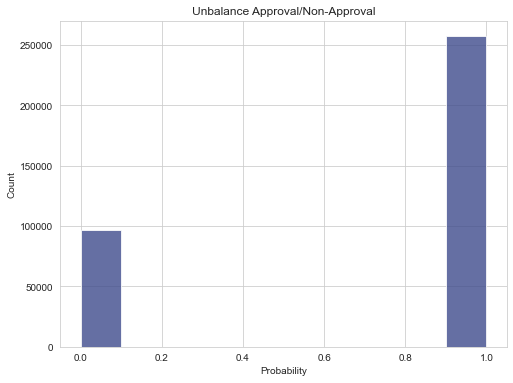

In [20]:
plt.figure(figsize=(8,6))
plt.hist(lar['action_taken'],facecolor='#3F4B8C',alpha=0.8)
plt.ylabel('Count')
plt.xlabel('Probability')
plt.title('Unbalance Approval/Non-Approval');

While our metric of interest is unbalanced, it is not extremely so.

I have already mentioned that I expect income to be an important feature of our data. However, it comes in a few different forms. Let's examine our income data and look at how we might transform them below.

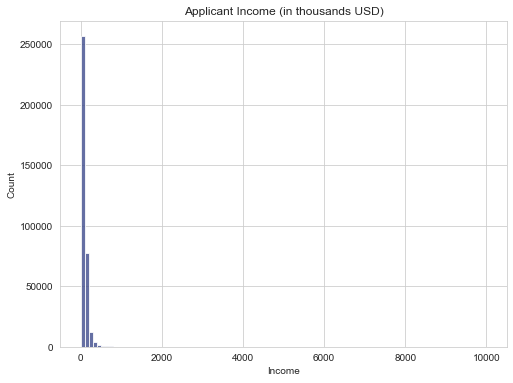

In [21]:
lar.loc[:,'applicant_income_000s'] = pd.to_numeric(lar.loc[:,'applicant_income_000s'])
plt.figure(figsize=(8,6))
plt.hist(lar.loc[:,'applicant_income_000s'],100,facecolor='#3F4B8C',alpha=0.8)
plt.ylabel('Count')
plt.xlabel('Income')
plt.title('Applicant Income (in thousands USD)');

We can see here that this data has a very log-normal looking distribution (i.e. very long right tail). Most models that we will consider have an underlying assumption that the data is normally distributed. It will be important for us to keep the underlying model assumptions in mind through our analysis process.

To address this in the income data, we will perform a log transformation. 

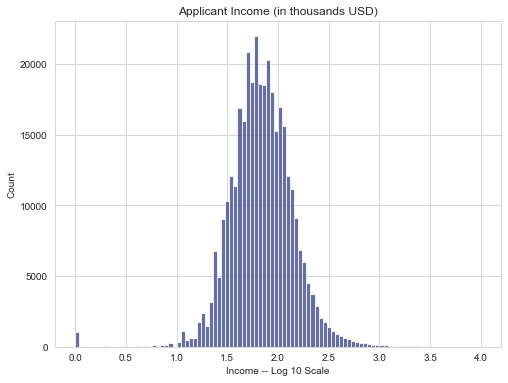

In [22]:
plt.figure(figsize=(8,6))
plt.hist(lar.loc[:,'applicant_income_000s'].apply(lambda x: math.log(x,10)),100, \
        facecolor='#3F4B8C',alpha=0.8)
plt.ylabel('Count')
plt.xlabel('Income -- Log 10 Scale')
plt.title('Applicant Income (in thousands USD)');

First, you may notice that I chose a base 10 for the log transform. In this case I prefer to work on base 10 for interpretation as it tends to be easier to work in units of 10. Also notice that all of our values are above zero. We could scale this distribution to be above/beow average being above and below zero. This again comes down to distribution. I don't expect above or below average income to be especially important for acceptance, rather it will be proportional to the loan amount. I will always default to less transformation where possible with a keen focus on interpretation.

You will also notice now that the ditribution is much more normal looking, but we can also see a very strang blip around zero. Under closer inspection, these are entries of $1 for applicant income. For our purposes, we will filter these outliers from our dataset as they are likely an entry or other type of input error.

In [23]:
start_obs = lar.shape[0]
lar = lar[(lar.loc[:,'applicant_income_000s'] != 1)]
"""dropped {:,.0f} observations""".format(start_obs - lar.shape[0])

'dropped 1,013 observations'

In [24]:
"""The Range of our data is from {} up to {:,.0f}""".format(min(lar.loc[:,'applicant_income_000s']), \
                                                      max(lar.loc[:,'applicant_income_000s']))

'The Range of our data is from 2 up to 9,999'

Looking at the new range of our data, we can still see an arbitrarily low number of 2 and an equally suspcious high number of 9999. While these are also likely to be entries which are less than accurate, just as in the case of missing data, they can still be informative and I have kept these in the dataset. For instance, perhaps they represent sentiment of the loan officer. In any case, looking at our new distribution they don't cause the same type of outlier problem we witnessed before

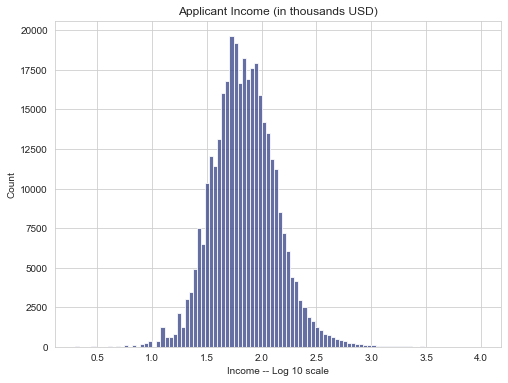

In [25]:
plt.figure(figsize=(8,6))
plt.hist(lar.loc[:,'applicant_income_000s'].apply(lambda x: math.log(x,10)),100, \
        facecolor='#3F4B8C',alpha=0.8)
plt.ylabel('Count')
plt.xlabel('Income -- Log 10 scale')
plt.title('Applicant Income (in thousands USD)');

Taking a look at another example variable, let's look at the number of units in an area that are built to house less than 5 families. This is a good metric, beyond population, for density of an area.

/home/edmund/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/edmund/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


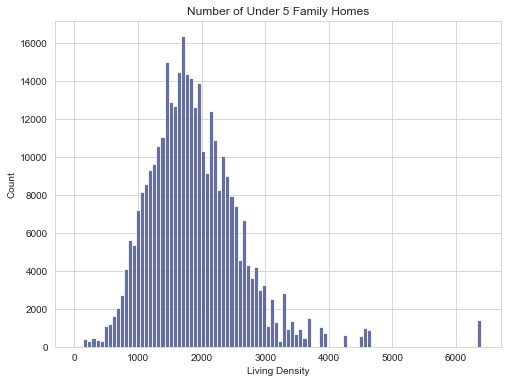

In [26]:
lar['number_of_1_to_4_family_units'] = pd.to_numeric(lar.loc[:,'number_of_1_to_4_family_units'])
plt.figure(figsize=(8,6))
plt.hist(lar.loc[:,'number_of_1_to_4_family_units'], 100, facecolor='#3F4B8C',alpha=0.8)
plt.ylabel('Count')
plt.xlabel('Living Density')
plt.title('Number of Under 5 Family Homes');

Again here we have a very strong right tailed distribution. However, in this case moving to a log scale would only shift that right tail to a left tail. Furthermore, looking at the Shapiro-Wilk test of normaily the transformation would move the metric from 0.92 to 0.99. I would not consider that to be a large enough change to be compelling. A large reason for this are the outliers to the right. However, these are likely meaningful observations within cities. As such, it wouldn't make much sense to remove these outliers.

In this case, I don't think removing outliers makes sense but I do think scaling the data to be above or below average has more interpretive power. So this is the route I will take when scaling.

/home/edmund/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/edmund/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


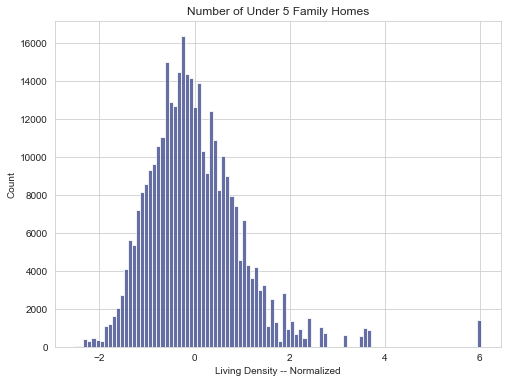

In [27]:
from sklearn import preprocessing
plt.figure(figsize=(8,6))
plt.hist(preprocessing.scale(lar.loc[:,'number_of_1_to_4_family_units']), 100, facecolor='#3F4B8C',alpha=0.8)
plt.ylabel('Count')
plt.xlabel('Living Density -- Normalized')
plt.title('Number of Under 5 Family Homes');

Up to this point, we have looked at numerical data. However, a large part of this dataset is categorical. So let us take a quick look at some of those examples.

The first of these examples is whether or not the applicant was the sole applicant (i.e. had a co-applicant or not).

In [28]:
pd.DataFrame(set(lar.loc[:,'co_applicant_ethnicity_name']),columns=['Co-Applicant Race']).head()

,Co-Applicant Race
0,Not Hispanic or Latino
1,"Information not provided by applicant in mail,..."
2,Not applicable
3,No co-applicant
4,Hispanic or Latino


In [29]:
soleApplicant = np.zeros(lar.shape[0])
lar.loc[:,'co_applicant_ethnicity'] = pd.to_numeric(lar.loc[:,'co_applicant_ethnicity'])
ids = (lar.loc[:,'co_applicant_ethnicity'] == 5)
soleApplicant[ids] = 1

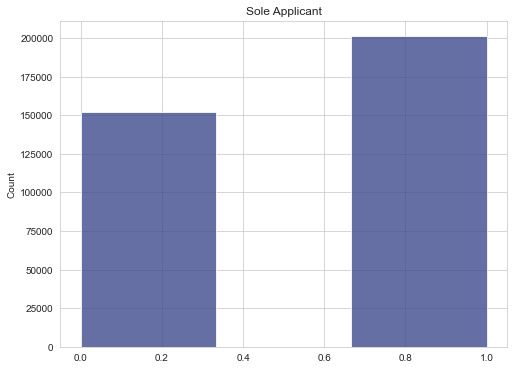

In [30]:
plt.figure(figsize=(8,6))
plt.hist(soleApplicant,3 , facecolor='#3F4B8C',alpha=0.8)
plt.ylabel('Count')
plt.title('Sole Applicant');

Our data also has some detailed information about the race of the applicant and co-applicant. In this example I won't prepare a binary variable for each race. This is not because they are not all important to look at, but rather the focus of this document is on process. So we will focus on the most common categores and leave a more in-depth study for later.

The groups we look at are:
1. Black or African American
2. Asian
3. All other Non-White races

Setting up our variables this way should give us a clear indication of any bias.

In [31]:
blackApplicant = np.zeros(lar.shape[0])
ids = (lar.loc[:,'applicant_race_name_1'] == 'Black or African American')
blackApplicant[ids] = 1

asianApplicant = np.zeros(lar.shape[0])
ids = (lar.loc[:,'applicant_race_name_1'] == 'Asian')
asianApplicant[ids] = 1

otherRaceApplicant = np.ones(lar.shape[0])
ids = (lar.loc[:,'applicant_race_name_1'] == 'White')
otherRaceApplicant[ids] = 0
ids = (lar.loc[:,'applicant_race_name_1'] == 'Black or African American')
otherRaceApplicant[ids] = 0
ids = (lar.loc[:,'applicant_race_name_1'] == 'Asian')
otherRaceApplicant[ids] = 0

white_pct = sum(lar.loc[:,'applicant_race_name_1'] == 'White')/lar.shape[0]

pd.DataFrame([{'black': round(sum(blackApplicant)/lar.shape[0],2),
  'asian': round(sum(asianApplicant)/lar.shape[0], 2),
  'other race': round(sum(otherRaceApplicant)/lar.shape[0], 2),
  'white': round(white_pct,2)}])

,asian,black,other race,white
0,0.02,0.06,0.11,0.81


Another variable we will consider around race is that sometimes a non-white applicant could have a co-applicant that is white. Given race is an important consideration here for our regulatory purposes, we want to control for the mitigating effect that having a white co-applicant may have. We will call this variable 'white friend'.

In [32]:
white_friend = np.zeros(lar.shape[0])
ids = (lar.loc[:,'applicant_race_name_1'] != 'White') & (lar.loc[:,'co_applicant_race_name_1'] == 'White')
white_friend[ids] = 1
"""{:,.0f} non-white applicants have a white co-applicant""".format(sum(white_friend))

'2,502 non-white applicants have a white co-applicant'

We have a rather extensive dataset, so I won't go through all of my logic on choosing, normalizing, and transforming the data here. I hope the above section gives you some insight into my thought process and you will be able to see my other choices in the relevant code.

Recall, that we are combining different datasets and we would like our process to be scalable. In order to make that possible we will create a series of functions that will:
<br />
1. Extract and merge our data from the database.
<br />
2. Do the preprocessing and make the necessary transformations 

The first is merging our HMDA data with the data we gathered from the census bureau.

In [33]:
merge_query = {0: 'select lar.action_taken, lar.applicant_income_000s, lar.applicant_race_name_1, \
lar.co_applicant_race_name_1, lar.applicant_sex, lar.lien_status, lar.loan_purpose, lar.loan_type, \
lar.agency_code, lar.owner_occupancy, lar.preapproval,lar.property_type, lar.purchaser_type_name, \
lar.hud_median_family_income, lar.loan_amount_000s, lar.number_of_1_to_4_family_units, \
lar.number_of_owner_occupied_units, \
lar.minority_population, lar.population, lar.tract_to_msamd_income, census.emp, census.estab, census.payann, \
census.pop, census.county_code, census.county_name, census.state_code from lar LEFT JOIN census ON \
lar.county_code = census.county_code AND lar.state_code = 39'}

In [34]:
from queries import get_query
from preproc import trans_actions

In [35]:
merged_data = get_query(merge_query[0])

Establishing Connection
Connection Successful
Connection Close


In [36]:
merged_data.shape

(493271, 27)

In [37]:
# preprocessing the data
input_data = trans_actions(merged_data)

What we have just done above is combine two earlier steps in a scalable process. As we add data to the data base, either as it comes in or as we collect it, we are able to merge that data with supporting information, clean it, and also do transformations that get it ready to use. In terms of process I believe that this should be the type of goal folks should focus on.

### Initial Modelling and Learning
Having all of our data in order, we can begin to look at our features and how they are related to our metric of interest (i.e. approval of a mortgage)

In [38]:
# some quick descriptors
input_data.describe()

,approved,income_log,sole_applicant,black_applicant,asian_applicant,other_race,white_friend,is_female,first_lien,refinancing,...,is_farmer,hud_spread,inc_loan_ratio,low_density,self_owned,area_pop,local_income_ratio,emp_pop,estab_pop,pay_pop
count,338349.000000,338349.000000,338349.000000,338349.000000,338349.000000,338349.000000,338349.000000,338349.000000,338349.000000,338349.000000,...,338349.000000,3.383490e+05,338349.000000,3.383450e+05,3.383170e+05,338347.000000,3.383450e+05,3.383490e+05,3.383490e+05,338349.000000
mean,0.760100,1.843276,0.568877,0.056350,0.021658,0.108054,0.007093,0.424919,0.936019,0.446317,...,0.000012,-9.414850e-16,0.198017,1.069977e-16,-1.470159e-16,3.671409,-4.670520e-17,-1.861466e-16,6.128725e-16,4.525455
std,0.427023,0.295091,0.495234,0.230597,0.145565,0.310449,0.083922,0.619592,0.244720,0.497111,...,0.003438,1.000001e+00,0.351687,1.000001e+00,1.000001e+00,0.185827,1.000001e+00,1.000001e+00,1.000001e+00,0.564035
min,0.000000,0.301030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-2.442938e+01,-3.300987,-2.506042e+00,-2.118067e+00,0.000000,-2.762753e+00,-2.347389e+00,-3.680542e+00,2.540318
25%,1.000000,1.653213,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,-6.483943e-01,0.077605,-6.468468e-01,-6.627686e-01,3.559308,-6.450742e-01,-8.554725e-01,-7.080881e-01,4.112584
50%,1.000000,1.832509,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,-4.450110e-02,0.266268,-1.179380e-01,-1.221886e-01,3.679337,-1.555197e-01,-7.996825e-02,6.809463e-02,4.629593
75%,1.000000,2.025306,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,6.025379e-01,0.413004,5.151499e-01,5.336202e-01,3.793930,4.891788e-01,1.031352e+00,7.847645e-01,5.119691
max,1.000000,3.999957,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,...,1.000000,7.583277e+00,2.442480,6.013932e+00,6.108707e+00,4.268905,7.063125e+00,1.622187e+00,1.806047e+00,5.319408


In [39]:
# Correlations show where the strongest relationships exist
pd.options.display.float_format = '{:,.3F}'.format
input_data.corr()

,approved,income_log,sole_applicant,black_applicant,asian_applicant,other_race,white_friend,is_female,first_lien,refinancing,...,is_farmer,hud_spread,inc_loan_ratio,low_density,self_owned,area_pop,local_income_ratio,emp_pop,estab_pop,pay_pop
approved,1.000,0.174,-0.095,-0.097,0.018,-0.066,0.004,-0.065,0.127,-0.210,...,0.002,0.167,0.052,0.049,0.076,0.069,0.130,0.026,0.030,0.032
income_log,0.174,1.000,-0.383,-0.091,0.048,0.029,0.040,-0.114,0.043,0.062,...,0.004,0.981,-0.332,0.088,0.157,0.128,0.406,0.105,0.124,0.119
sole_applicant,-0.095,-0.383,1.000,0.101,0.005,0.010,-0.097,0.148,-0.043,-0.067,...,-0.000,-0.382,0.108,-0.061,-0.089,-0.078,-0.152,0.043,0.025,0.037
black_applicant,-0.097,-0.091,0.101,1.000,-0.036,-0.085,0.099,0.017,-0.048,-0.025,...,-0.001,-0.108,-0.023,-0.076,-0.102,-0.090,-0.139,0.165,0.129,0.155
asian_applicant,0.018,0.048,0.005,-0.036,1.000,-0.052,0.121,-0.045,0.023,-0.021,...,-0.001,0.037,0.037,0.030,0.044,0.056,0.080,0.069,0.061,0.075
other_race,-0.066,0.029,0.010,-0.085,-0.052,1.000,0.092,0.526,-0.012,0.074,...,-0.001,0.024,-0.020,-0.012,-0.010,-0.007,0.014,0.039,0.036,0.038
white_friend,0.004,0.040,-0.097,0.099,0.121,0.092,1.000,0.016,0.010,-0.005,...,-0.000,0.039,-0.005,0.003,0.005,0.006,0.012,0.013,0.009,0.012
is_female,-0.065,-0.114,0.148,0.017,-0.045,0.526,0.016,1.000,-0.037,0.029,...,0.002,-0.119,-0.005,-0.030,-0.038,-0.033,-0.049,0.058,0.046,0.055
first_lien,0.127,0.043,-0.043,-0.048,0.023,-0.012,0.010,-0.037,1.000,0.167,...,0.001,0.036,0.639,0.033,0.047,0.051,0.062,0.015,0.010,0.016
refinancing,-0.210,0.062,-0.067,-0.025,-0.021,0.074,-0.005,0.029,0.167,1.000,...,0.000,0.060,0.063,0.009,0.025,0.019,0.058,-0.003,0.010,0.001


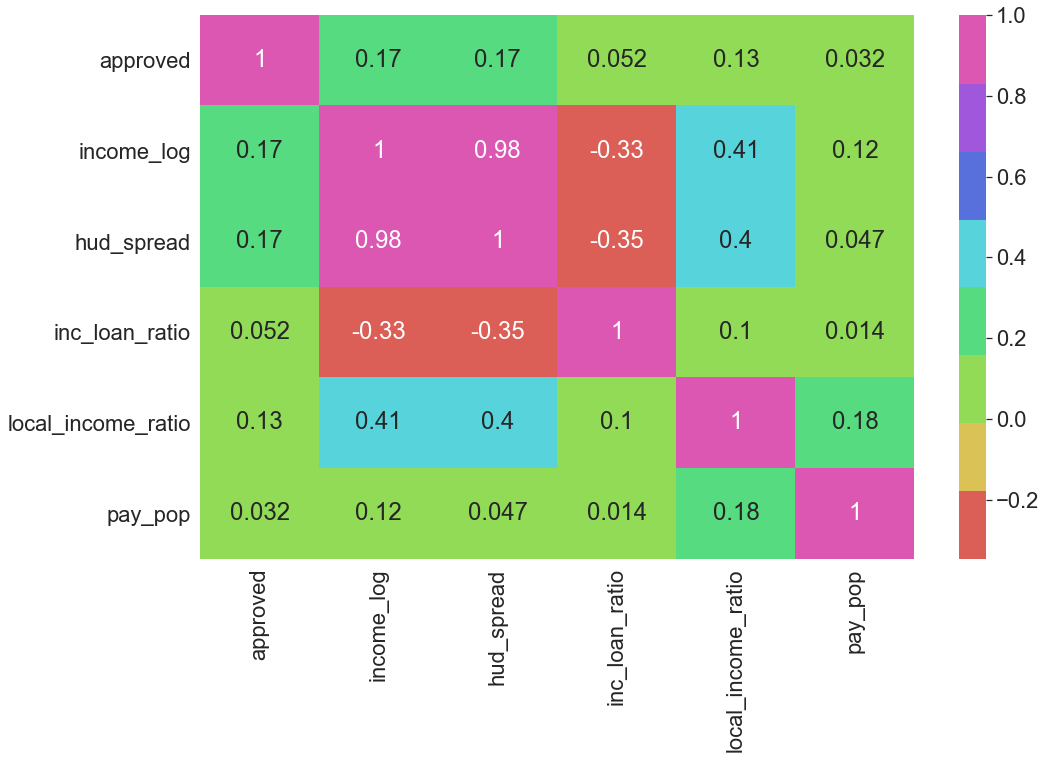

In [40]:
# Easier to focus on a grouping, in this case income related metrics
plt.figure(figsize=(16,10))
sns.set(font_scale=2)
sns.heatmap(input_data.loc[:,['approved','income_log','hud_spread','inc_loan_ratio','local_income_ratio','pay_pop']].corr(), annot = True, cmap=sns.color_palette("hls", 8))
plt.show()

In the graphic above, we can see some strong relationships. Both income and the spread of a person's income over the hud median family income are the same. In fact, on closer inspection these two metrics are 98% correlated. This could cause issues for us and our modelling. It would be safest for us to choose one or the other or dig deeper on how to get more information from our spread metric and remove the overall income effect from it (i.e. a form of dimension reduction perhaps?)

Below, we switch from income to ethnicity and gender. These are low metrics, but they do go along with pre-existing bias we may have had. It would be interesting to look at individual instituions to see if this is more prevelent in a few bad actors or a systemic issue.

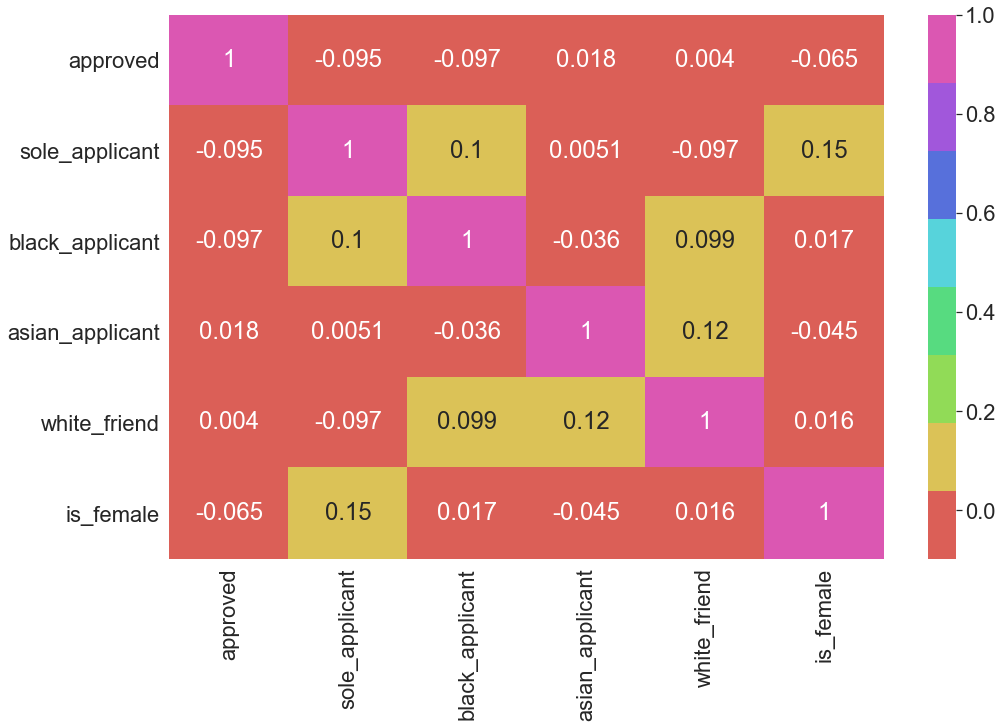

In [41]:
plt.figure(figsize=(16,10))
sns.set(font_scale=2)
sns.heatmap(input_data.loc[:,['approved','sole_applicant','black_applicant','asian_applicant','white_friend','is_female']].corr(), annot = True, cmap=sns.color_palette("hls", 8))
plt.show()

### Modelling
Our first model we will turn to the workhorse of classification, the Logistic Regression. This model often works extremely well for these types of problems. In essence, this model is link to a function which quickly goes from 0 to 1 which is well suited to the type of binary classifcation we are attempting here. I would normally use a standard model like this for benchmarking any further machine learning or other approaches.

Looking at our initial output we see a few interesting things. First, as confirmed in our earlier analysis looking at income only, you are more than likely to recieve a mortgage. Given the output below a person in the bottom 25th percential would break even with the intercept. So, while income is important it isn't an especially high bar. That said, the botton 25% does make up a substantial proportion of the population.

Moving on to our ethnicity and race metrics we do see being African American doesn't help. Unfortunately, with a p-value which is very strong. The effects are not as convincing for being Asian or female, but they are equally consistent in p-value terms with other race applicants with those of African Americans.

Lots of interesting results here to look through here.


<img src='https://raw.githubusercontent.com/ewalsh/hmda/master/images/GLMoutput.png?token=AASHOBXL3UIDSTQG2BTFYES6XBPZY'
     alt='GLM output'
     style='height: 800px; width: 1000px;'
     />

As we have an unbalanced dataset, it will be important to think about our false positives as well as true positives. Confusion matrices are a good way to look at this information, but being more graphical, I tend to prefer area under the curve graphics. We can see this for our Logistic Regression below.

<img src='https://raw.githubusercontent.com/ewalsh/hmda/master/images/InitialLogit.png?token=AASHOBWTEZNE5PCDNZVY24S6XBRNY'
     alt='GLM output'
     style='height: 800px; width: 1000px;'
     />

This is a pretty good first run. The total Area Under the Curve metric for this model is roughly 75%.

We have included a lot of variables in this first model. This leaves us open to bias. Normally, there is a trade-off between variance around the model and bias which lead to under or over fitting. There are many ways to think about combating this but a first look would just be looking at the loads of the model.

<img src='https://raw.githubusercontent.com/ewalsh/hmda/master/images/LogitLoads.png?token=AASHOBT3OU3NPUW2XPXLBMC6XBSGM'
     alt='GLM output'
     style='height: 600px; width: 1000px;'
     />

We have looked at this information from the model before, but this gives us a sense of feature importance (although I would adjust to variance of the underlying metrics) as well as a sense that no single feature dominates the model. Income, by far the most important isn't double the next few metrics and we did expect it to be strong to begin with

Another important technique we should exploit is cross-validation. This is closely tied to the idea of a learning curve where as we begin to feed more data into the model how much more accurate does it become, or perhaps, does the prediction deterioate out of sample due to overconfidence. 

We are only looking at a single state and single year for now and then randomizing the observations within a training and testing sample. I would expect this to become more difficult as regional difference become more important. For now, let's just see how the area under the curve metrics changes over different trials.

<img src='https://raw.githubusercontent.com/ewalsh/hmda/master/images/CVlogit.png?token=AASHOBS2S32GXIRYQWUGWJK6XBUR4'
     alt='GLM output'
     style='height: 600px; width: 1000px;'
     />
     
For the moment, our logistic regression seems to be very consistent. Again, a good start made possible by the foundations we set ealier.

The logistic regression is a workhorse function because it works very well. We are trying to fit a line to best predict a 1 or 0. However, what if we flip our approach and try to fit a line that splits our 1s from our 0s. This is the approach of a Support Vector Machine (SVM). 

<img src='https://raw.githubusercontent.com/ewalsh/hmda/master/images/SVM.png?token=AASHOBSIYBQVG5GKPJZ3DDS6XBWZ6'
     alt='SVM output'
     style='height: 600px; width: 1000px;'
     />
     
We can see here that the SVM has more false positive than the logistic regression.

### Optimize
These models have shown themselves to be a good place to start, but as we get more into our data and modelling we may be able to exploit parameter tuning, optimization techniques, regularization, or deep learning. These models should be used with care, but can be very powerful. For an example, I will use a Elastic Net model below which is basically a step further on our Logistic Regression. Elastic Net is a form of Generalized Additive Model and can be useful for feature selection as well as stability through regularization of the L1 and L2 norms, which effectively combat outliers and bias. We will simply split our data to run our test.

In [42]:
xcols = input_data.columns
xcols = xcols[1:xcols.shape[0]]
X_train = input_data.loc[0:3000,xcols]
y_train = input_data.loc[0:3000,'approved']
X_test = input_data.loc[3001:5000,xcols]
y_test = input_data.loc[3001:5000,'approved']

In [43]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve

In [44]:
clf = SGDClassifier(random_state = 0, loss='log', penalty='elasticnet')
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [45]:
y_train_pred = cross_val_predict(clf, X_train, y_train, cv=100)

In [46]:
c_mat = confusion_matrix(y_train, y_train_pred)
c_mat

array([[ 194,  107],
       [  98, 1818]])

In [47]:
# The Negative Class
"""{} True Negatives and {} False Positives""".format(c_mat[0,0],c_mat[0,1])

'194 True Negatives and 107 False Positives'

In [48]:
# The Positive Class
"""{} False negatives and {} True Positives""".format(c_mat[1,0],c_mat[1,1])

'98 False negatives and 1818 True Positives'

In [49]:
"""{:,.2F} Precision""".format(precision_score(y_train,y_train_pred))

'0.94 Precision'

In [50]:
"""{:,.2F} Recall""".format(recall_score(y_train,y_train_pred))

'0.95 Recall'

<Figure size 3600x3600 with 0 Axes>

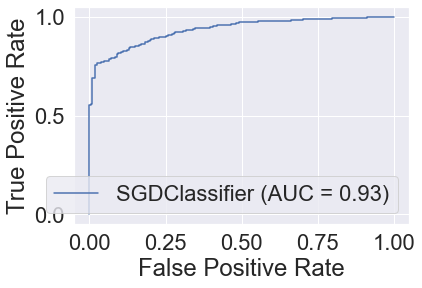

In [51]:
plt.figure(figsize=(50,50))
plot_roc_curve(clf, X_test, y_test)
plt.show()

We can see that this learning model provides substational improvement, moving our AUC measure from around 0.75 to 0.93. This is with minimal tuning, but it is still worth being wary as we have yet to scale up the process.

### Conclusion
In this project we have focused on building a scalable process for analysis. I believe we have successfully met those goals as we have a data ingestion pipeline as well as cleaning and transformation that lead to an analytics process that while early stages, shows substation potential.

Keeping all of this in the context we set, with an AUC measure of 93%, this would be a high bar for any human to beat and so we could provide cost savings to mortgage lenders and/or help them make their lending deicisons. We have also highlighted some suspect race and gender issues that could become regulatory issues in the future. It is worth further study here. 

<br />
Finally, we have brought together many dataset relevant to the mortgage decision and financial instituions. This has set a strong foundation for us going forward and combining with our analytics we can see which institutions may need the most guidance/help or perhaps may just be unaware that they could lend more/less aggressively and with less bias.